## LSTM-ED for Anomaly Detection in Time Series Data

In [1]:

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset import *
from plots import *
from metrics import *
from models_funtions import *

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [2]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

#### Variours parameters

In [3]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

file_name_normal = "_20220811_rbtc_"
file_name_collisions = "_collision_20220811_rbtc_"

recording_normal = [0, 2, 3, 4]
recording_collisions = [1, 5]

features_folder_normal = "../features/normal/"
features_folder_collisions = "../features/collisions/"

### Data

In [4]:
df_features_normal, df_normal_raw, _ = get_dataframes(ROOTDIR_DATASET_NORMAL, file_name_normal, recording_normal, freq, f"{features_folder_normal}")
df_features_collisions, df_collisions_raw, df_collisions_raw_action = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, recording_collisions, freq, f"{features_folder_collisions}1_5/")
df_features_collisions_1, df_collisions_raw_1, df_collisions_raw_action_1 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [1], freq, f"{features_folder_collisions}1/")
df_features_collisions_5, df_collisions_raw_5, df_collisions_raw_action_5 = get_dataframes(ROOTDIR_DATASET_ANOMALY, file_name_collisions, [5], freq, f"{features_folder_collisions}5/")

Loading data.
Found 31 different actions.
Loading data done.

Loading features from file.
--- 2.2558271884918213 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Loading features from file.
--- 0.01512289047241211 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Loading features from file.
--- 0.012552499771118164 seconds ---
Loading data.
Found 31 different actions.
Loading data done.

Loading features from file.
--- 0.012690544128417969 seconds ---


In [5]:
X_train, y_train, X_test, y_test, df_test = get_train_test_data(df_features_normal, df_features_collisions, full_normal=True)
X_train_1, y_train_1, X_test_1, y_test_1, df_test_1 = get_train_test_data(df_features_normal, df_features_collisions_1, full_normal=True)
X_train_5, y_train_5, X_test_5, y_test_5, df_test_5 = get_train_test_data(df_features_normal, df_features_collisions_5, full_normal=True)

c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(
c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(
c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but VarianceThreshold was fitted with feature names
  warnings.warn(


### Collisions

In [6]:
collisions_rec1, collisions_init1 = get_collisions('1', ROOTDIR_DATASET_ANOMALY)
collisions_rec5, collisions_init5 = get_collisions('5', ROOTDIR_DATASET_ANOMALY)

# Merge the collisions of the two recordings in one dataframe
collisions_rec = pd.concat([collisions_rec1, collisions_rec5])
collisions_init = pd.concat([collisions_init1, collisions_init5])

In [7]:
collisions_zones, y_collisions = get_collisions_zones_and_labels(collisions_rec, collisions_init, df_features_collisions)
collisions_zones_1, y_collisions_1 = get_collisions_zones_and_labels(collisions_rec1, collisions_init1, df_features_collisions_1)
collisions_zones_5, y_collisions_5 = get_collisions_zones_and_labels(collisions_rec5, collisions_init5, df_features_collisions_5)

## LSTM-AD for Anomaly Detection in Time Series Data

In [8]:
from algorithms.lstm_ad import LSTMAD

def prepare_data_for_lstm(data, len_in):
    """
    Prepare data for LSTM-AD by concatenating every len_in rows.
    """
    n_features = data.shape[1]
    n_samples = data.shape[0] // len_in
    prepared_data = data.iloc[:n_samples * len_in].values.reshape(n_samples, -1)
    return pd.DataFrame(prepared_data, index=data.index[len_in-1:len_in*n_samples:len_in])

# CURRENTLY FUCKS UP FOR VALUES OF LEN_IN AND LEN_OUT DIFFERENT FROM 1
len_in = 1
X_train_lstm = prepare_data_for_lstm(X_train, len_in)
print(X_train_lstm.shape)

classifier = LSTMAD(
    len_in=len_in,         # Input sequence length
    len_out=1,             # Output sequence length (prediction horizon)
    num_epochs=100,         # Number of training epochs
    lr=1e-2,               # Learning rate
    batch_size=1,          # Batch size (usually 1 for time series)
    seed=42,               # Random seed for reproducibility
    gpu=None,              # Set to None for CPU, or specify GPU index if available
    details=True           # Set to True to get detailed predictions
)

# Train the LSTM on normal data
classifier.fit(X_train_lstm)
print("LSTM-AD training completed.")


(973, 96)


100%|██████████| 100/100 [00:37<00:00,  2.65it/s]

LSTM-AD training completed.


### Predictions

Anomaly prediction completed.
Number of anomalies detected: 12 with threshold 21092.127605639944, std
Number of anomalies detected: 101 with threshold 2290.6479999701914, mad
Number of anomalies detected: 16 with threshold 17665.710055886426, percentile
Number of anomalies detected: 20 with threshold 14844.393177684564, IQR
Number of anomalies detected: 306 with threshold 0.0, zero

choosen threshold type: mad, with value: 2290.6480
F1 Score: 0.8252
Accuracy: 0.8824
Precision: 0.8416
Recall: 0.8095
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       201
           1       0.84      0.81      0.83       105

    accuracy                           0.88       306
   macro avg       0.87      0.86      0.87       306
weighted avg       0.88      0.88      0.88       306

ROC AUC Score: 0.9422


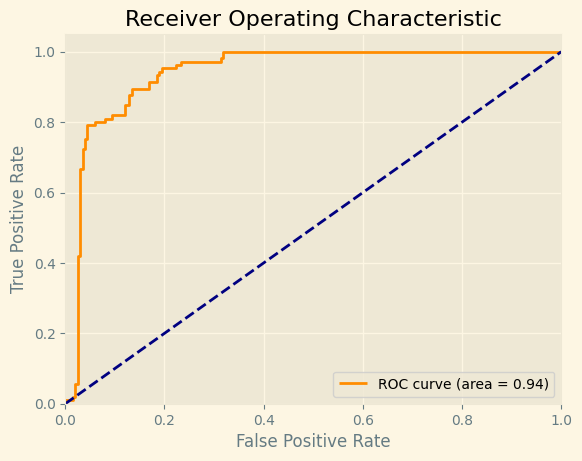

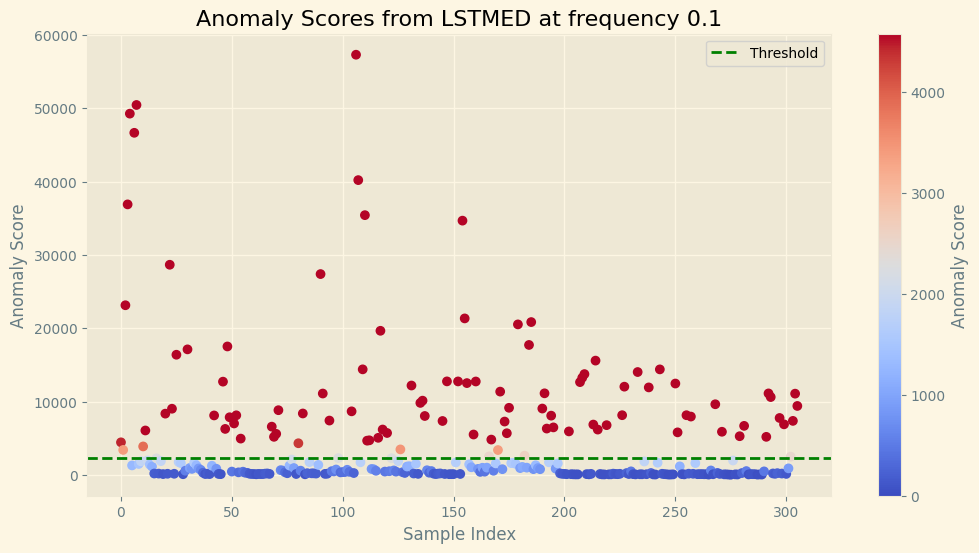

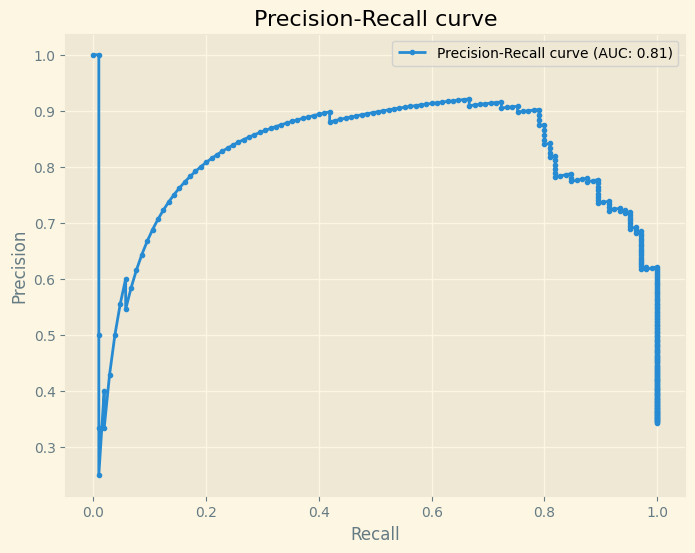

Anomalies detected: 101
Best threshold: 4665.8229 | F1 Score: 0.8426 | Precision: 0.9022 | Recall: 0.7905

	-------------------------------------------------------------------------------------

Anomaly prediction completed.
Number of anomalies detected: 8 with threshold 16295.887090143526, std
Number of anomalies detected: 52 with threshold 1041.14685093989, mad
Number of anomalies detected: 9 with threshold 12530.401874141493, percentile
Number of anomalies detected: 18 with threshold 3659.0468832779898, IQR
Number of anomalies detected: 164 with threshold 0.0, zero

choosen threshold type: mad, with value: 1041.1469
F1 Score: 0.7126
Accuracy: 0.8476
Precision: 0.5962
Recall: 0.8857
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       129
           1       0.60      0.89      0.71        35

    accuracy                           0.85       164
   macro avg       0.78      0.86      0.80       164
weighted avg       0.89      0.85 

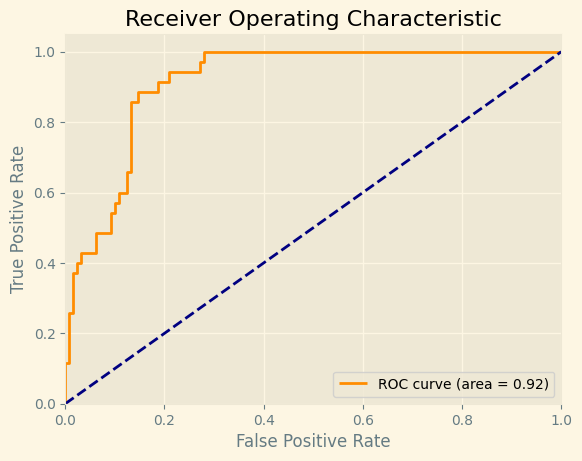

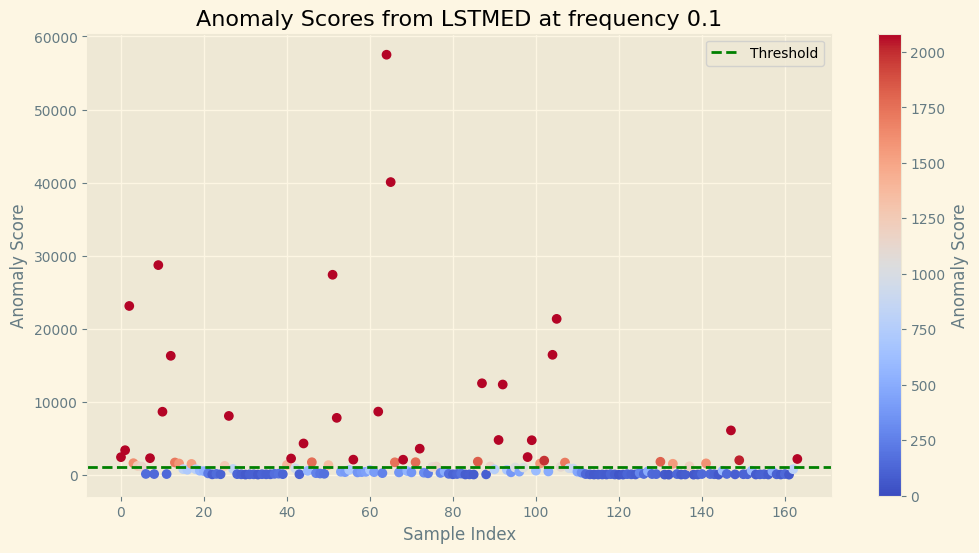

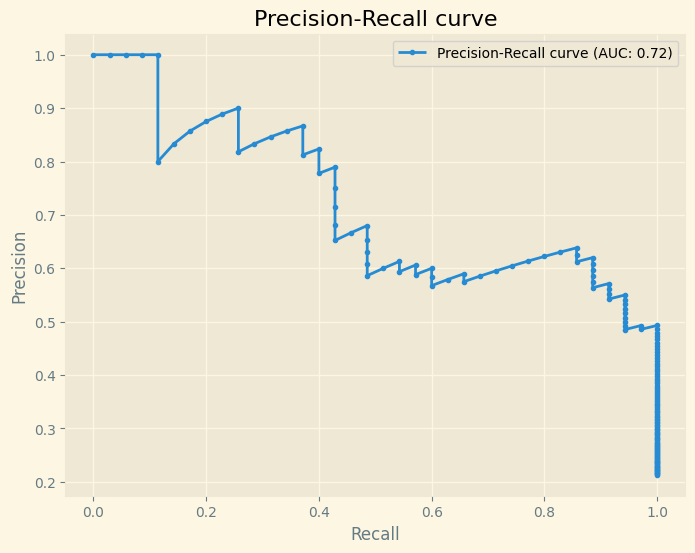

Anomalies detected: 52
Best threshold: 1202.8576 | F1 Score: 0.7317 | Precision: 0.6383 | Recall: 0.8571

	-------------------------------------------------------------------------------------

Anomaly prediction completed.
Number of anomalies detected: 4 with threshold 20438.12083421122, std
Number of anomalies detected: 12 with threshold 13984.141798806526, mad
Number of anomalies detected: 8 with threshold 17298.704087222137, percentile
Number of anomalies detected: 4 with threshold 20632.80860488017, IQR
Number of anomalies detected: 141 with threshold 0.0, zero

choosen threshold type: mad, with value: 13984.1418
F1 Score: 0.2941
Accuracy: 0.6596
Precision: 0.8333
Recall: 0.1786
              precision    recall  f1-score   support

           0       0.64      0.98      0.78        85
           1       0.83      0.18      0.29        56

    accuracy                           0.66       141
   macro avg       0.74      0.58      0.53       141
weighted avg       0.72      0.66  

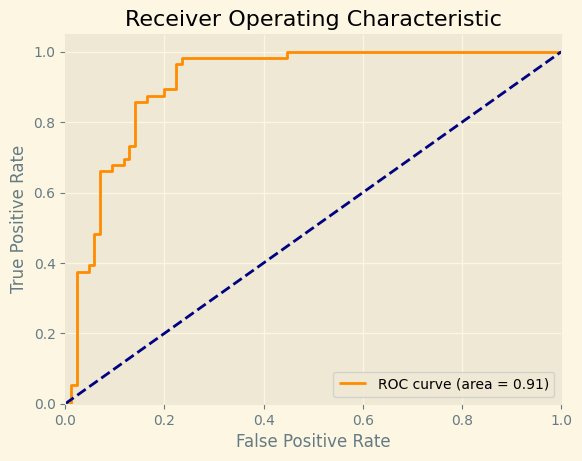

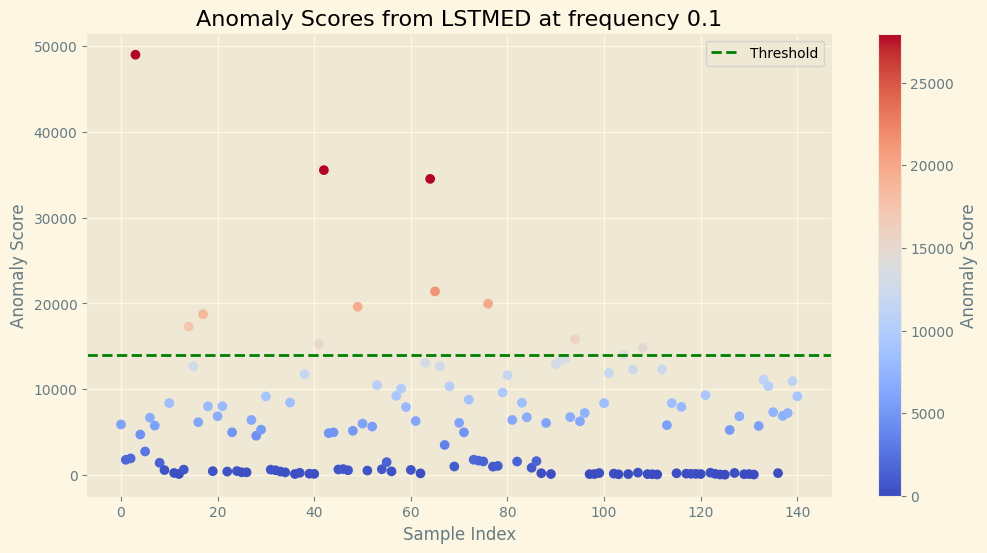

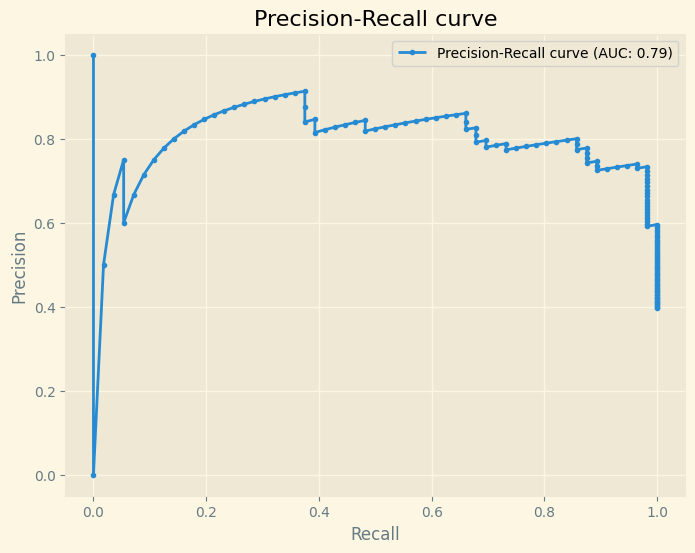

Anomalies detected: 12
Best threshold: 4570.4729 | F1 Score: 0.8397 | Precision: 0.7333 | Recall: 0.9821

	-------------------------------------------------------------------------------------



c:\Users\VG User\Documents\GitHub\MLinAPP-FP01-14\src\models_funtions.py:68: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [9]:
df_test = get_statistics(X_test, y_collisions, classifier, df_test, freq, threshold_type="mad")
df_test_1 = get_statistics(X_test_1, y_collisions_1, classifier, df_test_1, freq, threshold_type="mad")
df_test_5 = get_statistics(X_test_5, y_collisions_5, classifier, df_test_5, freq, threshold_type="mad")

In [10]:
plot_anomalies_true_and_predicted(df_collisions_raw, df_collisions_raw_action, collisions_zones, df_test, title="Collisions zones vs predicted zones for both recordings")

In [11]:
plot_anomalies_true_and_predicted(df_collisions_raw_1, df_collisions_raw_action_1, collisions_zones_1, df_test_1, title="Collisions zones vs predicted zones for recording 1")

In [12]:
plot_anomalies_true_and_predicted(df_collisions_raw_5, df_collisions_raw_action_5, collisions_zones_5, df_test_5, title="Collisions zones vs predicted zones for recording 5")